In [206]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import RFECV, RFE
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB

pd.set_option("display.max_columns", None)

In [84]:
bank_logit = pd.read_csv("../data/bank_selected.csv")
bank_raw = pd.read_csv("../data/bank_imputed_imp.csv")

In [85]:
bank_logit.head()

bank_X = bank_logit.drop(columns = ["y"])
bank_y = bank_logit["y"]
bank_poutcome = bank_raw["poutcome"]
bank_raw_X = bank_raw.drop(columns = ["y", "poutcome"])
bank_raw_y = bank_raw["y"]

In [86]:
# Weighted logistic regression
logit = LogisticRegression(penalty = "none", max_iter = 500, class_weight = "balanced")
logit = logit.fit(bank_X, bank_y)
logit.score(bank_X, bank_y)

0.7569437700301058

In [87]:
selector = RFE(LogisticRegression(max_iter = 1000, class_weight = "balanced"))
selector = selector.fit(bank_X, bank_y)
logit_feature = bank_X.columns[selector.support_]

In [88]:
logit_rfe = LogisticRegression(penalty = "none", max_iter = 500, class_weight = "balanced")
logit_rfe_fit = logit_rfe.fit(bank_X[logit_feature], bank_y)
print(f"Accuracy: {logit_rfe_fit.score(bank_X[logit_feature], bank_y)}")
print(f'Recall: {recall_score(bank_y, logit_rfe_fit.predict(bank_X[logit_feature]), average = "binary")}')
print(f'Mean accuracy via CV: {np.mean(cross_val_score(logit_rfe, bank_X[logit_feature], bank_y))}')
print(f'Mean recall via CV: {np.mean(cross_validate(logit_rfe, bank_X[logit_feature], bank_y, scoring = "recall_macro")["test_score"])}')

logit_rfe_fit.coef_

Accuracy: 0.7706613576769933
Recall: 0.5877155172413793
Mean accuracy via CV: 0.34890666033800843
Mean recall via CV: 0.41928242428154017


array([[ 0.68169361, -0.25251088, -0.12108791,  0.71190389, -0.25844017,
         0.69471273, -0.15149594,  0.17967724, -0.16612299, -0.13498487,
         0.84744576,  0.94971336, -0.74357954,  1.27386311, -0.69772151,
         1.34343882, -0.76985968, -0.8172445 ,  1.13026548,  0.86447649,
        -0.18770545]])

In [89]:
# Regularization
logit_cv = LogisticRegressionCV(penalty = "l2", class_weight = "balanced", scoring = "f1_macro", n_jobs = -1)
logit_cv_fit = logit_cv.fit(bank_X[logit_feature], bank_y)

print(f"Accuracy: {logit_cv_fit.score(bank_X[logit_feature], bank_y)}")
print(f'Recall: {recall_score(bank_y, logit_cv_fit.predict(bank_X[logit_feature]), average = "binary")}')
print(f'Mean accuracy via CV: {np.mean(cross_validate(logit_cv, bank_X[logit_feature], bank_y, scoring = "accuracy")["test_score"])}')
print(f'Mean recall via CV: {np.mean(cross_validate(logit_cv, bank_X[logit_feature], bank_y, scoring = "recall_macro")["test_score"])}')

logit_cv.coef_

Accuracy: 0.5851439373622296
Recall: 0.5825431034482759
Mean accuracy via CV: 0.43524239111632285
Mean recall via CV: 0.4998230075618343


array([[ 0.2357671 , -0.07286052, -0.00819838,  0.05050841, -0.02617746,
         0.0356366 , -0.01038185,  0.05782463, -0.00722483, -0.0366348 ,
         0.0004874 ,  0.16666415, -0.01971426,  0.01520224, -0.03737882,
         0.04692464, -0.123663  , -0.01955015,  0.04988686,  0.03870097,
        -0.02292014]])

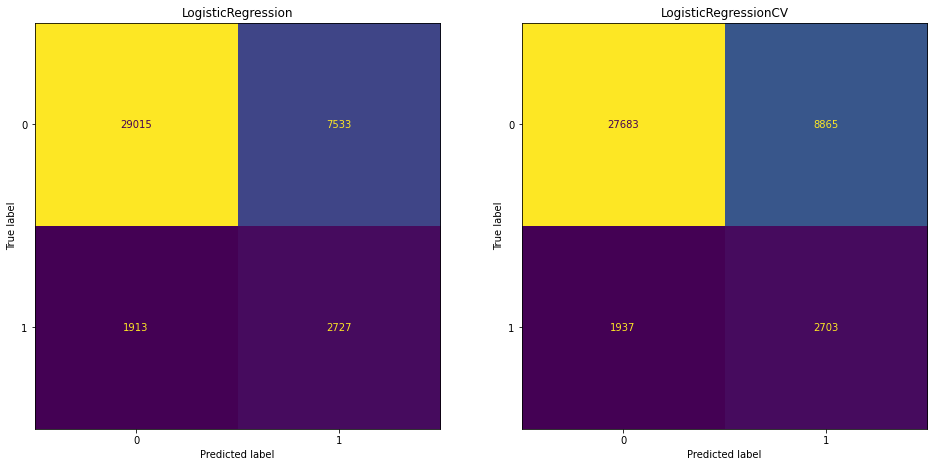

In [90]:
# Confusion matrix
models = [logit_rfe_fit, logit_cv_fit]
fig, ax = plt.subplots(1, 2, figsize = (16, 16))
for i in range(len(models)):
    pred = models[i].predict(bank_X[logit_feature])
    cm = confusion_matrix(bank_y, pred, labels = models[i].classes_)

    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = models[i].classes_)
    disp.plot(ax = ax[i], colorbar = False)
    ax[i].set_title(str(models[i]).split("(")[0])


In [98]:
# Random forest
bank_raw_X = bank_raw_X.join(bank_poutcome)

In [92]:
def plot_imporatance(model):
    importance = model.feature_importances_[model.feature_importances_ != 0]
    feature = bank_raw_X.columns[model.feature_importances_ != 0]

    feature_importance = np.sort(np.stack((feature, importance), axis = 1), axis = 0)[::-1]
    np.sum(feature_importance[:, 1])

    feature = [i[0] for i in feature_importance]
    importance = [i[1] for i in feature_importance]

    plt.figure(figsize = (16, 8))
    plt.barh(feature, importance, height = 0.75)
    plt.title("Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

In [197]:
# rf = RandomForestClassifier(class_weight = "balanced", n_jobs = -1, max_samples = 0.2)
rf = RandomForestClassifier(class_weight = "balanced", min_weight_fraction_leaf = 0.4, max_samples = 0.2)

In [198]:
rf_fit = rf.fit(bank_raw_X, bank_raw_y)

In [ ]:
# tuning = GridSearchCV(estimator = rf, param_grid = {"n_estimators": np.arange(100, 510, 10)}, cv = 5, verbose = True, n_jobs = -1, scoring = "f1_macro").fit(bank_raw_X, bank_raw_y).best_params_

In [199]:
np.mean(cross_validate(rf, bank_raw_X, bank_raw_y, n_jobs = -1, scoring = "accuracy", cv = 10)["test_score"])

0.6543633248874162

In [200]:
np.mean(cross_validate(rf, bank_raw_X, bank_raw_y, n_jobs = -1, scoring = "recall_macro", cv = 10)["test_score"])

0.670635967498467

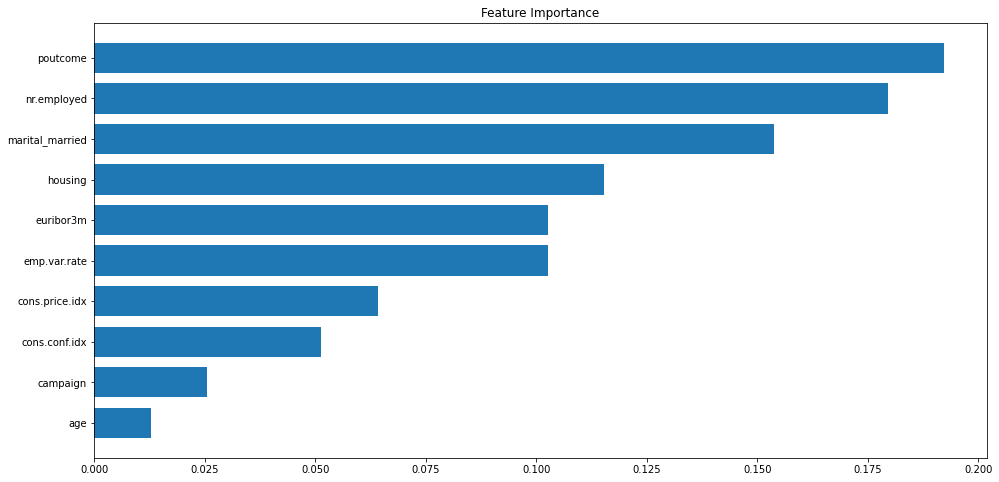

In [201]:
plot_imporatance(rf_fit)

In [208]:
# SVM

svc = make_pipeline(StandardScaler(), SVC(gamma = 'auto', class_weight = "balanced", kernel = "linear"))
svc_fit = svc.fit(bank_X, bank_y)
# SVM is very resource consuming, and it is not easy to interpret despite possible high accuracy


In [ ]:
#
